In [1]:
from IPython.display import clear_output


# !pip install tensorflow
# !pip install  spacy
# !pip install tqdm
# !pip install plotly
!pip install jupyter-black
!pip install imblearn


clear_output()

## Data preprocessing

### Import libraries

In [2]:
import csv
import re
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
%load_ext jupyter_black

In [4]:
np.set_printoptions(precision=4)

### Import data

In [5]:
path = "data/"
# Read sequences
sequences = list()
with open(path + "sequences.txt", "r") as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
train_target = list()
with open(path + "graph_labels.txt", "r") as f:
    for i, line in enumerate(f):
        t = line.split(",")
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            train_target.append(int(t[1][:-1]))

sequences_train = np.array(sequences_train)
train_target = np.array(train_target)
sequences_test = np.array(sequences_test)

In [6]:
data = pd.DataFrame({"seq": sequences_train, "target": train_target})

In [7]:
unseen = pd.DataFrame({"seq": sequences_test})

<AxesSubplot:>

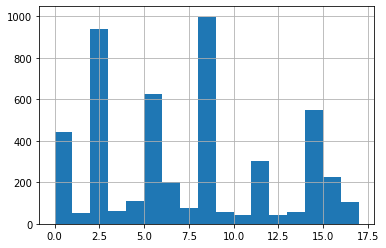

In [8]:
data.target.hist(bins=17)

In [9]:
mean_carr = np.mean(data.seq.progress_apply(len))
std_carr = np.std(data.seq.progress_apply(len))
print(mean_carr)
print("mean", mean_carr, "and std is", std_carr)

  0%|          | 0/4888 [00:00<?, ?it/s]

  0%|          | 0/4888 [00:00<?, ?it/s]

258.14279869067104
mean 258.14279869067104 and std is 162.24346887570542


We notice that the target isn't balanced, so we will take that into consideration by :
- adding sample weight in logistic regression and the other models that supports weight to impact directly the loss function
- we can make an oversampling using duplication which is poor or using smote (that add some guassian noise )
- we can make an undersampling by reducing the number of majority class samples

### Important functions 

In [10]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x


softmax_vect = np.vectorize(softmax)

In [11]:
# weighted multi-class log loss
from sklearn.metrics import log_loss


def weighted_mc_log_loss(y_true, y_pred, y_pred_proba):
    loss = log_loss(y_true, y_pred_proba, labels=np.unique(y_true))
    accuracy = round((y_true == y_pred).sum() / len(y_true) * 100, 2)
    return print(f"{loss = } and accuracy {accuracy = }")

In [12]:
def submit(y_pred_proba):
    # Write predictions to a file
    with open("../Submissions/sample_submission.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        lst = list()
        for i in range(18):
            lst.append("class" + str(i))
        lst.insert(0, "name")
        writer.writerow(lst)
        for i, protein in enumerate(proteins_test):
            lst = y_pred_proba[i, :].tolist()
            lst.insert(0, protein)
            writer.writerow(lst)

# using structure

In [13]:
import torch

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [14]:
import time
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim


def load_data():
    """
    Function that loads graphs
    """
    graph_indicator = np.loadtxt(path + "graph_indicator.txt", dtype=np.int64)
    _, graph_size = np.unique(graph_indicator, return_counts=True)

    edges = np.loadtxt(path + "edgelist.txt", dtype=np.int64, delimiter=",")
    edges_inv = np.vstack((edges[:, 1], edges[:, 0]))
    edges = np.vstack((edges, edges_inv.T))
    s = edges[:, 0] * graph_indicator.size + edges[:, 1]
    idx_sort = np.argsort(s)
    edges = edges[idx_sort, :]
    edges, idx_unique = np.unique(edges, axis=0, return_index=True)
    A = sp.csr_matrix(
        (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
        shape=(graph_indicator.size, graph_indicator.size),
    )

    x = np.loadtxt(path + "node_attributes.txt", delimiter=",")
    edge_attr = np.loadtxt(path + "edge_attributes.txt", delimiter=",")
    edge_attr = np.vstack((edge_attr, edge_attr))
    edge_attr = edge_attr[idx_sort, :]
    edge_attr = edge_attr[idx_unique, :]

    adj = []
    features = []
    edge_features = []
    idx_n = 0
    idx_m = 0
    for i in range(graph_size.size):
        adj.append(A[idx_n : idx_n + graph_size[i], idx_n : idx_n + graph_size[i]])
        edge_features.append(edge_attr[idx_m : idx_m + adj[i].nnz, :])
        features.append(x[idx_n : idx_n + graph_size[i], :])
        idx_n += graph_size[i]
        idx_m += adj[i].nnz

    return adj, features, edge_features

In [15]:
def normalize_adjacency(A):
    """
    Function that normalizes an adjacency matrix
    """
    n = A.shape[0]
    A += sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D = sp.diags(inv_degs)
    A_normalized = D.dot(A)

    return A_normalized


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Function that converts a Scipy sparse matrix to a sparse Torch tensor
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [16]:
# Load graphs
adj, features, edge_features = load_data()

# Normalize adjacency matrices
adj = [normalize_adjacency(A) for A in adj]

# Split data into training and test sets
adj_train = list()
features_train = list()
edge_features_train = list()
y_train = list()
adj_test = list()
features_test = list()
edge_features_test = list()
proteins_test = list()

In [17]:
with open(path + "graph_labels.txt", "r") as f:
    for i, line in enumerate(f):
        t = line.split(",")
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            adj_test.append(adj[i])
            features_test.append(features[i])
            edge_features_test.append(edge_features[i])
        else:
            adj_train.append(adj[i])
            features_train.append(features[i])
            edge_features_train.append(edge_features[i])
            y_train.append(int(t[1][:-1]))

In [18]:
# adj_train = adj_train[:50].copy()
# features_train = features_train[:50].copy()
# edge_features_train = edge_features_train[:50].copy()
# y_train = y_train[:50].copy()

In [19]:
import joblib as joblib

features_train = joblib.load("new_features.sav")
features_test = joblib.load("new_features_test.sav")
n_input = features_train[0].shape[1]

In [20]:
# from sklearn.decomposition import PCA


# data_pca = np.concatenate(features_train, axis=0)

# pca = PCA(n_components=50)
# pca.fit(data_pca)

# print(pca.explained_variance_ratio_)

# print(pca.explained_variance_ratio_.sum())

# print(pca.singular_values_)

In [21]:
# features_train = [pca.transform(i) for i in features_train]

In [22]:
from torch_geometric.data import Data


def get_Data(adj_train, features_train, edge_features_train, y_train):
    data = []
    for i in range(len(features_train)):
        adj_t = torch.tensor(adj_train[i].todense())
        edge_index = adj_t.nonzero().t().contiguous()
        x = torch.tensor(features_train[i]).float()
        edge_attr = torch.tensor(edge_features_train[i]).float()

        data.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_train[i]))
    return data


data_obj = get_Data(adj_train, features_train, edge_features_train, y_train)

In [23]:
def get_Data_pred(adj_train, features_train, edge_features_train):
    data = []
    for i in range(len(features_train)):
        adj_t = torch.tensor(adj_train[i].todense())
        edge_index = adj_t.nonzero().t().contiguous()
        x = torch.tensor(features_train[i]).float()
        edge_attr = torch.tensor(edge_features_train[i]).float()

        data.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr))
    return data


data_obj_pred = get_Data_pred(adj_test, features_test, edge_features_test)

In [24]:
train_dataset = data_obj[: int(len(data_obj) * 9 / 10)]
test_dataset = data_obj[int(len(data_obj) * 9 / 10) :]

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Number of training graphs: 4399
Number of test graphs: 489


In [25]:
from torch_geometric.loader import DataLoader, NeighborLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
pred_loader = DataLoader(data_obj_pred, batch_size=32, shuffle=False)

In [26]:
# neigh_loader = []
# for i in range(len(train_dataset)):
#     loader = NeighborSampler(
#         train_dataset[i].edge_index, sizes=[30], batch_size=32, shuffle=True
#     )
#     sampled_data = next(iter(loader))
#     neigh_loader.append(sampled_data)
# train_loader = DataLoader(neigh_loader, batch_size=32, shuffle=True)

In [27]:
for step, data in enumerate(train_loader):
    if step < 5:
        print(f"Step {step + 1}:")
        print("=======")
        print(f"Number of graphs in the current batch: {data.num_graphs}")
        print(data)
        print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[7702, 406], edge_index=[2, 138742], edge_attr=[138742, 5], y=[32], batch=[7702], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[6987, 406], edge_index=[2, 127067], edge_attr=[127067, 5], y=[32], batch=[6987], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[7683, 406], edge_index=[2, 141669], edge_attr=[141669, 5], y=[32], batch=[7683], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[9105, 406], edge_index=[2, 171035], edge_attr=[171035, 5], y=[32], batch=[9105], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[6918, 406], edge_index=[2, 123498], edge_attr=[123498, 5], y=[32], batch=[6918], ptr=[33])



# Train

In [28]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv, GINConv, global_add_pool, SAGEConv
from torch_geometric.nn import global_mean_pool, global_max_pool

num_node_features = features_train[0].shape[1]
num_classes = 18


class GNN(torch.nn.Module):
    def __init__(
        self,
        model_name="GCN",
        hidden_channels=[512, 256, 256],  # [128, 64, 32]
        num_heads=[1, 1, 1],  # [1, 1, 1]
        dropout=0.2,
        n_classes=num_classes,
        input_dim=num_node_features,
    ):
        super(GNN, self).__init__()
        self.n_classes = n_classes
        self.dropout = dropout
        self.hidden_dim = hidden_channels[2]
        self.model_name = model_name

        if model_name == "GCN":
            self.layer1 = GCNConv(in_channels=-1, out_channels=hidden_channels[0])
            self.layer2 = GCNConv(
                in_channels=hidden_channels[0], out_channels=hidden_channels[1]
            )
            # self.layer3 = GCNConv(
            #     in_channels=hidden_channels[1], out_channels=hidden_channels[2]
            # )
            self.decoder = nn.Linear(hidden_channels[1], n_classes)  # [2]

        elif model_name == "GAT":
            self.layer1 = GATConv(
                in_channels=-1,
                out_channels=hidden_channels[0],
                heads=num_heads[0],
                edge_dim=5,
            )
            self.layer2 = GATConv(
                hidden_channels[0] * num_heads[0],
                hidden_channels[1],
                heads=num_heads[1],
                edge_dim=5,
            )
            self.layer3 = GATConv(
                hidden_channels[1] * num_heads[1],
                hidden_channels[2],
                heads=1,
                edge_dim=5,
                concat=False,
            )
            self.decoder = nn.Linear(hidden_channels[2], n_classes)

        elif model_name == "GraphSAGE":
            self.layer1 = SAGEConv(input_dim, hidden_channels[0], aggr="lstm")
            self.layer2 = SAGEConv(hidden_channels[0], hidden_channels[1], aggr="lstm")
            self.layer3 = SAGEConv(hidden_channels[1], hidden_channels[2], aggr="lstm")
            self.decoder = nn.Linear(hidden_channels[2], n_classes)

        # self.decoder = nn.Linear(hidden_channels[2], n_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        if self.model_name == "GAT":
            x = self.layer1(x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

            x = self.layer2(x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

            x = self.layer3(x, edge_index, edge_attr)
        else:
            x = self.layer1(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

            x = self.layer2(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

            # x = self.layer3(x, edge_index)
        # x = F.relu(x)
        x = global_max_pool(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.decoder(x)
        return x
        # return F.log_softmax(x, dim=-1)


model = GNN().to(device)
print(model)

GNN(
  (layer1): GCNConv(-1, 512)
  (layer2): GCNConv(512, 256)
  (decoder): Linear(in_features=256, out_features=18, bias=True)
)


In [29]:
# from torch.nn import Linear
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv
# from torch_geometric.nn import global_mean_pool

# num_node_features = features_train[0].shape[1]
# num_classes = 18


# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, hidden_channels)
#         self.lin = Linear(hidden_channels, num_classes)

#     def forward(self, x, edge_index, _, batch):
#         # 1. Obtain node embeddings
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         x = self.conv3(x, edge_index)

#         # 2. Readout layer
#         x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

#         # 3. Apply a final classifier
#         # x = F.dropout(x, p=0.2, training=self.training)
#         x = self.lin(x)

#         return x


# model = GCN(hidden_channels=64).to(device)
# print(model)

In [30]:
# model = GCN(hidden_channels=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)


def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(
            data.x, data.edge_index, data.edge_attr, data.batch
        )  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.


def test(loader):
    model.eval()
    loss = 0
    correct = 0
    for i, data in enumerate(
        loader
    ):  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        loss += criterion(out, data.y)
    return correct / len(loader.dataset) * 100, loss / (
        i + 1
    )  # Derive ratio of correct predictions. , proba


min_val_loss = float("inf")
for epoch in range(1, 401):
    train()
    train_acc, train_loss = test(train_loader)
    test_acc, test_loss = test(test_loader)
    if epoch % 1 == 0:
        # Evaluate model
        model.eval()
        # val_loss = log_loss(y_val, y_pred_proba, labels=np.unique(y_val))
        print(
            "Epoch: {:03d}".format(epoch + 1),
            "loss_train: {:.4f}".format(train_loss),
            "acc_train: {:.4f}".format(train_acc),
            "loss_val: {:.4f}".format(test_loss),
            "acc_val: {:.4f}".format(test_acc),
        )
        if min_val_loss > test_loss:
            print(
                f"Validation Loss Decreased({min_val_loss:.6f}--->{test_loss:.6f}) \t Saving The Model"
            )
            min_val_loss = test_loss
            # Saving State Dict
            torch.save(model.state_dict(), "saved_model_esm.pth")
            print("\n")
        else:
            print("Validation loss increased :(")
        # print(f"Epoch: {epoch:03d}")

Epoch: 002 loss_train: 2.3078 acc_train: 38.5997 loss_val: 2.4192 acc_val: 25.5624
Validation Loss Decreased(inf--->2.419173) 	 Saving The Model


Epoch: 003 loss_train: 2.1171 acc_train: 40.0546 loss_val: 2.5091 acc_val: 26.1759
Validation loss increased :(
Epoch: 004 loss_train: 1.9987 acc_train: 43.5099 loss_val: 2.1208 acc_val: 36.6053
Validation Loss Decreased(2.419173--->2.120836) 	 Saving The Model


Epoch: 005 loss_train: 1.7643 acc_train: 50.1705 loss_val: 1.9486 acc_val: 42.3313
Validation Loss Decreased(2.120836--->1.948615) 	 Saving The Model


Epoch: 006 loss_train: 1.7031 acc_train: 51.9436 loss_val: 1.9298 acc_val: 43.5583
Validation Loss Decreased(1.948615--->1.929757) 	 Saving The Model


Epoch: 007 loss_train: 1.6566 acc_train: 52.7620 loss_val: 1.7714 acc_val: 45.6033
Validation Loss Decreased(1.929757--->1.771425) 	 Saving The Model


Epoch: 008 loss_train: 1.7027 acc_train: 53.0120 loss_val: 1.8382 acc_val: 46.6258
Validation loss increased :(
Epoch: 009 loss_train

RuntimeError: CUDA out of memory. Tried to allocate 408.00 MiB (GPU 0; 15.74 GiB total capacity; 8.32 GiB already allocated; 279.56 MiB free; 14.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [47]:
torch.cuda.empty_cache()

In [79]:
model.load_state_dict(torch.load("saved_model_esm.pth"))
model.eval()

GNN(
  (layer1): GCNConv(-1, 64)
  (layer2): GCNConv(64, 64)
  (layer3): GCNConv(64, 64)
  (decoder): Linear(in_features=64, out_features=18, bias=True)
)

In [80]:
softmax = nn.Softmax(dim=1)


def predict(loader):
    model.eval()

    correct = 0
    pred = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, _, data.batch)
        out = softmax(out)
        pred.append(out.to("cpu").numpy())
        # pred.append(out.argmax(dim=1))  # Use the class with highest probability.

    return np.concatenate(pred, axis=0)  # Derive ratio of correct predictions. , proba

In [85]:
with torch.no_grad():
    predictions = predict(pred_loader)

In [88]:
def submit(y_pred_proba):
    # Write predictions to a file
    with open("../Submissions/geometric_GCNcov.csv", "w") as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        lst = list()
        for i in range(18):
            lst.append("class" + str(i))
        lst.insert(0, "name")
        writer.writerow(lst)
        for i, protein in enumerate(proteins_test):
            lst = y_pred_proba[i, :].tolist()
            lst.insert(0, protein)
            writer.writerow(lst)

In [89]:
submit(predictions)

In [117]:
predictions[0].sum()

1.0